# Compare minimization algorithms
- no of iterations
- robustness for fuzzy inits

In [1]:
from read_ggp_run import *
from matplotlib.lines import Line2D


In [2]:
params_config =  {'mean_lambda': 'bound',
                'gamma_lambda': 'bound',
                'var_lambda': 'bound',
                'mean_q': 'bound',
                'gamma_q': 'bound',
                'var_q':'bound',
                'beta':'bound',
                'var_x':'bound',
                'var_g':'bound',
                'var_dx':'bound',
                'var_dg':'free'}


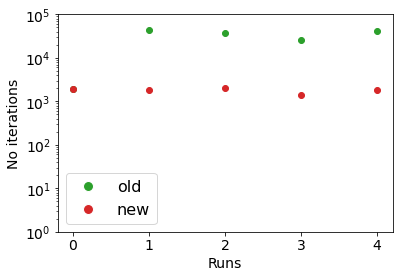

In [7]:
base_directory = '../data_2.0/test_minalgo_n250_sizer/'
sample = 'test_minalgo_n250_sizer_{:d}'
directory = base_directory + sample

fig, ax = plt.subplots()

for i in range(5):
    directory_i = directory.format(i)
    sample_i = sample.format(i)
    filebase = default_filebase(directory_i, sample_i) # default
    filebase_B = "../data_2.0/test_minalgo_n250_sizer/test_minalgo_n250_sizer_{:d}/LN_BOBYQA/test_minalgo_n250_sizer_{:d}".format(i, i)

    for fb, c in [ (filebase,"tab:green"), (filebase_B, "tab:red")]:
        iter_file, final_file = get_minimization_file(fb, params_config)

        mini_data = read_iteration_process(iter_file)
        iterations = mini_data.to_numpy()[:,0].astype(int)[-1]
        ax.scatter(i, iterations, c=c)
ax.set_yscale('log')
ax.set_ylim([1, 1e5])

labels = ["old", "new"]
colors = ["tab:green", "tab:red"]
legend_elements = [Line2D([0],[0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) \
                        for l,c in zip(labels, colors)]

ax.legend(handles=legend_elements)
ax.set_ylabel("No iterations")
ax.set_xlabel("Runs")

plt.show()

In [ ]:
def plot_noisy_param_run(directory, sample, x_param_range, params_config, skip=0, cols=3, width=14, out_dir=None):
    """ plots the scan for all filenames as a grid """
    no_params = len(params_config)
    rows = np.ceil(no_params/cols).astype(int)
    fig, axes = plt.subplots(rows, cols, figsize=(width,0.7*width/cols*rows))
    ax = axes.ravel()
    for i, k in enumerate(params_config.items()):
        n = 0
        while n < len(x_param_range):
            j = n + skip
            if out_dir == None:
                directory_j = directory.format(j)
                sample_j = sample.format(j)
                filebase = default_filebase(directory_j, sample_j) # default
            else:
                filebase = out_dir.format(j, j)
            minimization_iter_file, minimization_final_file = get_minimization_file(filebase, params_config)

            if os.path.isfile(minimization_final_file):
                parameters_settings = read_params_config(minimization_final_file)
                final = get_params_config(parameters_settings, k[0])["final"].values[0]
                init = get_params_config(parameters_settings, k[0])["init"].values[0]
                ax[i].scatter(n, final, color="tab:blue")
                ax[i].scatter(n, init, color="tab:orange")
            n += 1

        # ax[i].ticklabel_format(style='sci', scilimits=(0,1), useOffset=False)
        ax[i].set_ylabel(k[0])
        ax[i].set_xlabel("run")
    for i in range(len(params_config), len(ax)):
        plt.delaxes(ax[i])
    plt.tight_layout()

    plt.show()

In [4]:
noise_levels = [0.3 for i in range(20)]
# noise_levels =noise_levels[:15]
plot_noisy_param_run('../data/fuzzy_param_guess_sizer/fuzzy_param_guess_sizer_{:d}', 'fuzzy_param_guess_sizer_{:d}', noise_levels,  {'mean_lambda': 'bound',
                'gamma_lambda': 'bound',
                'var_lambda': 'bound',
                'mean_q': 'bound',
                'gamma_q': 'bound',
                'var_q':'bound',
                'beta':'bound',
                'var_x':'bound',
                'var_g':'bound',
                'var_dx':'bound',
                'var_dg':'free'} , skip=0, cols=3, width=14)



NameError: name 'param_range' is not defined